<a href="https://colab.research.google.com/github/AhamadAli30/Defect-Detection-using-Deep-Learning/blob/main/Metal_Detection_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout

In [3]:
train_dir = '/content/drive/MyDrive/NEU Metal Surface Defects Data/train'
test_dir = '/content/drive/MyDrive/NEU Metal Surface Defects Data/test'
valid_dir = '/content/drive/MyDrive/NEU Metal Surface Defects Data/valid'

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=True)

valid_generator = test_datagen.flow_from_directory(valid_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

Found 1356 images belonging to 6 classes.
Found 372 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [5]:
# Check batch size
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32, 6)


In [6]:
# Check class names
class_names = train_generator.class_indices
class_names = list(class_names.keys())
print(class_names)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


In [ ]:
def get_sample_image(generator):
    images, labels = next(generator)
    image = images[0]
    label_index = np.argmax(labels[0])
    label_name = class_names[label_index]

    return image, label_name


def sample_images(generator, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    for i in range(nrows*ncols):
        image, label_name = get_sample_image(generator)
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis('off')

    plt.show()

In [ ]:
sample_images(train_generator, nrows=3, ncols=3)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnet(input_shape=(200, 200, 3), num_classes=6, num_blocks=[2, 2, 2, 2]):
    input_layer = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    for block_num, num_filters in enumerate([64, 128, 256, 512]):
        for i in range(num_blocks[block_num]):
            stride = 2 if i == 0 and block_num != 0 else 1
            x = residual_block(x, filters=num_filters, stride=stride)
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=input_layer, outputs=x, name='resnet')
    return model

resnet_model = build_resnet()
resnet_model.summary()


Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 100, 100, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 100, 100, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 100, 100, 64)         0         ['batch_normalization[0][

In [9]:
resnet_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [10]:
history = resnet_model.fit(train_generator,
                    epochs=10,
                    batch_size=32,
                    validation_data=valid_generator)

Epoch 1/10
43/43 [==============================] - 647s 15s/step - loss: 1.9928 - accuracy: 0.3953 - val_loss: 42.2189 - val_accuracy: 0.1962
Epoch 2/10
43/43 [==============================] - 23s 533ms/step - loss: 1.2880 - accuracy: 0.4941 - val_loss: 44.7276 - val_accuracy: 0.3199
Epoch 3/10
43/43 [==============================] - 24s 560ms/step - loss: 1.1030 - accuracy: 0.5929 - val_loss: 4.4614 - val_accuracy: 0.1667
Epoch 4/10
43/43 [==============================] - 23s 530ms/step - loss: 0.8402 - accuracy: 0.6888 - val_loss: 4.2363 - val_accuracy: 0.1667
Epoch 5/10
43/43 [==============================] - 23s 527ms/step - loss: 0.6933 - accuracy: 0.7684 - val_loss: 16.7906 - val_accuracy: 0.3118
Epoch 6/10
43/43 [==============================] - 22s 504ms/step - loss: 0.6436 - accuracy: 0.7832 - val_loss: 2.6952 - val_accuracy: 0.2849
Epoch 7/10
43/43 [==============================] - 23s 543ms/step - loss: 0.5573 - accuracy: 0.8112 - val_loss: 1.8820 - val_accuracy: 0.54

In [ ]:
# prompt: save the model in /content/drive/MyDrive/NEU Metal Surface Defects Data directory  along with its history

model_dir = '/content/drive/MyDrive/NEU Metal Surface Defects Data/'
model_name = 'ResNet_model.h5'
model_path = os.path.join(model_dir, model_name)
resnet_model.save(model_path)

history_path = os.path.join(model_dir, 'history.pkl')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)


In [ ]:
import pickle
resnet_model = pickle.load(open('/content/drive/MyDrive/NEU Metal Surface Defects Data/resnet_model.pkl', 'rb'))


In [11]:

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('categorical_crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

In [12]:
def plot_history(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

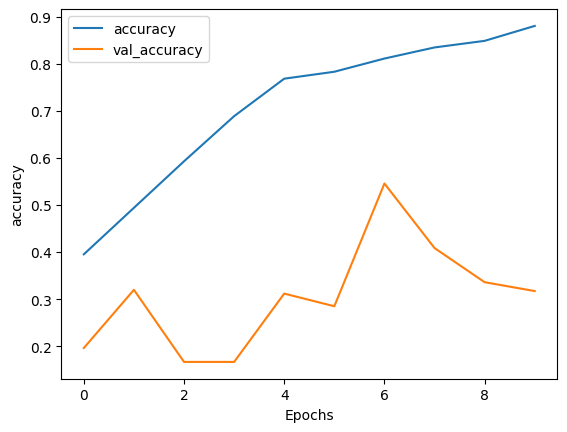

In [13]:
plot_history(history, 'accuracy')

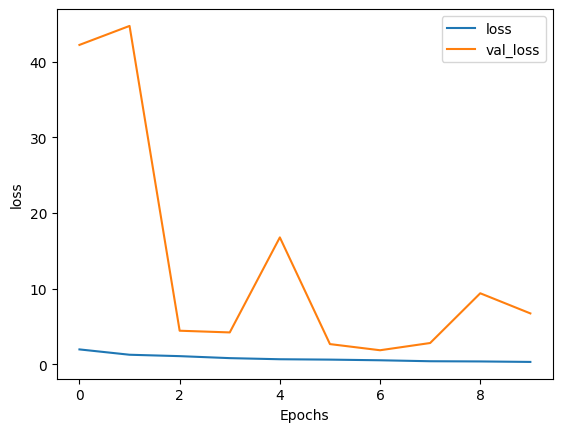

In [14]:
plot_history(history, 'loss')

In [16]:
result = resnet_model.evaluate(test_generator)
print("Test loss, Test accuracy : ", result)

3/3 [==============================] - 0s 94ms/step - loss: 3.6138 - accuracy: 0.4861
Test loss, Test accuracy :  [3.6137564182281494, 0.4861111044883728]


1/1 [==============================] - 0s 24ms/step


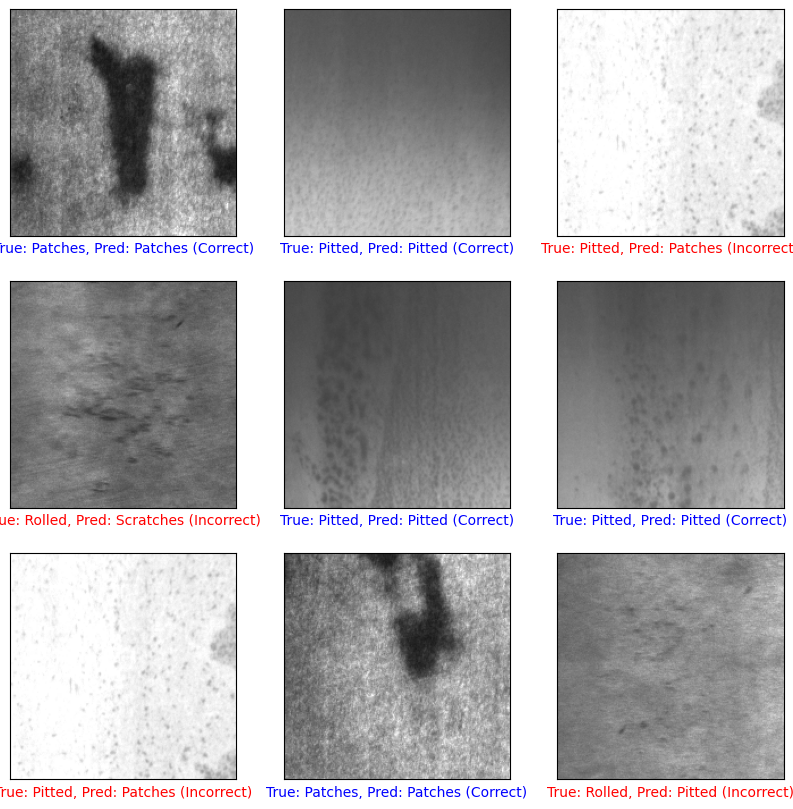

In [25]:
images, labels = next(test_generator)

indices = np.random.choice(range(len(images)), size=9)
images = images[indices]
labels = labels[indices]

predictions = resnet_model.predict(images)

class_names=list(test_generator.class_indices.keys())


plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = images[i]

    if image.shape[-1] == 1:
        image = np.squeeze(image)

    plt.imshow(image)

    predicted_label = np.argmax(predictions[i])

    if predicted_label == np.argmax(labels[i]):
        color='blue'
        result_text="Correct"

    else:
        color='red'
        result_text="Incorrect"

    label_text="True: "+ class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"

    plt.xlabel(label_text,color=color)

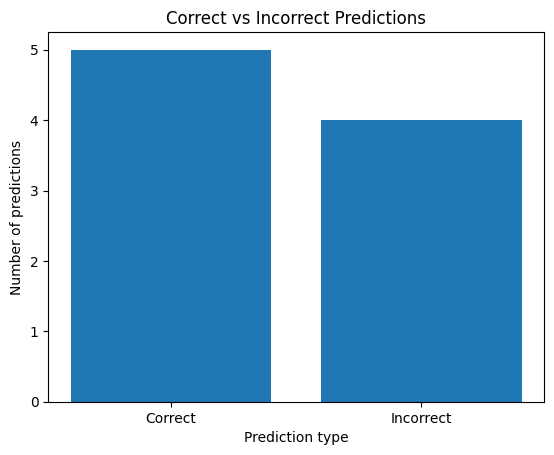

In [26]:
import matplotlib.pyplot as plt
import numpy as np
correct_predictions = 0
incorrect_predictions = 0

for i in range(len(predictions)):
  predicted_label = np.argmax(predictions[i])
  true_label = np.argmax(labels[i])

  if predicted_label == true_label:
    correct_predictions += 1
  else:
    incorrect_predictions += 1

labels = ['Correct', 'Incorrect']
values = [correct_predictions, incorrect_predictions]

plt.bar(labels, values)
plt.xlabel('Prediction type')
plt.ylabel('Number of predictions')
plt.title('Correct vs Incorrect Predictions')
plt.show()


3/3 [==============================] - 1s 102ms/step


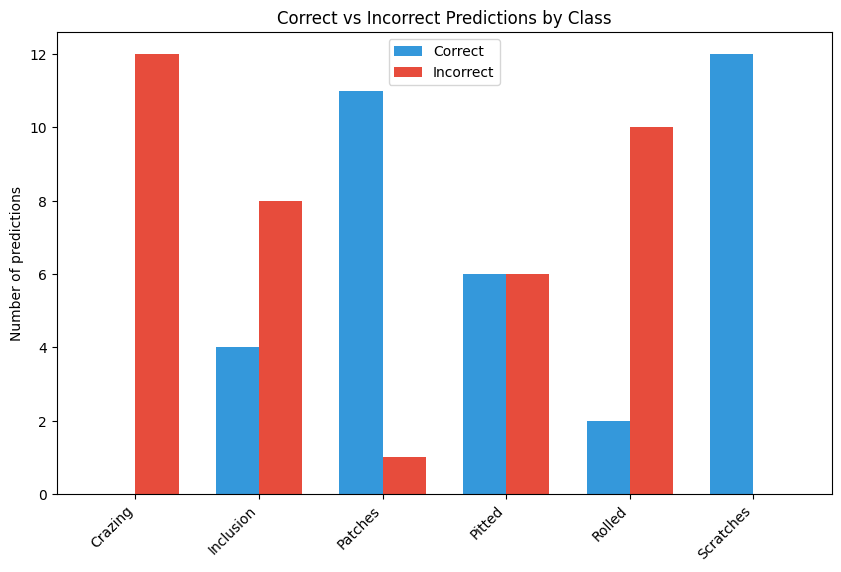

In [29]:
# prompt: give me bar graph for correct and wrong predictions of the model for each class

import numpy as np
import matplotlib.pyplot as plt

# Get the true labels for the test set
true_labels = test_generator.classes

# Get the predicted labels from the model
predicted_labels = np.argmax(resnet_model.predict(test_generator), axis=1)

# Initialize a dictionary to store the number of correct and incorrect predictions for each class
class_predictions = {}

# Loop through each class
for class_name in class_names:
  # Get the indices of the test samples belonging to the current class
  class_indices = np.where(true_labels == class_names.index(class_name))[0]

  # Get the predicted labels for the current class
  class_predicted_labels = predicted_labels[class_indices]

  # Calculate the number of correct and incorrect predictions for the current class
  correct_predictions = np.sum(class_predicted_labels == class_names.index(class_name))
  incorrect_predictions = len(class_indices) - correct_predictions

  # Store the results in the dictionary
  class_predictions[class_name] = {
      "correct": correct_predictions,
      "incorrect": incorrect_predictions
  }

# Create a bar chart showing the number of correct and incorrect predictions for each class
plt.figure(figsize=(10, 6))

x_labels = class_names
y_values = [
    [class_predictions[class_name]["correct"] for class_name in class_names],
    [class_predictions[class_name]["incorrect"] for class_name in class_names]
]

bar_width = 0.35
x_positions = np.arange(len(x_labels))

plt.bar(x_positions - bar_width/2, y_values[0], bar_width, label="Correct", color="#3498db")
plt.bar(x_positions + bar_width/2, y_values[1], bar_width, label="Incorrect", color="#e74c3c")

plt.xticks(x_positions, x_labels, rotation=45, ha="right")
plt.ylabel("Number of predictions")
plt.title("Correct vs Incorrect Predictions by Class")
plt.legend()
plt.show()
